# Solving a Fourth Order Elliptic Singular Perturbation Problem

$$
\left\{\begin{array}{lr}
\varepsilon^{2} \Delta^{2} u-\Delta u=f & \text { in } \Omega \\
u=\partial_{n} u=0 & \text { on } \partial \Omega
\end{array}\right.
$$

In [73]:
from skfem import *
import numpy as np
from skfem.visuals.matplotlib import draw, plot
from skfem.utils import solver_iter_krylov
from skfem.helpers import dd, ddot, grad
from scipy.sparse.linalg import LinearOperator, minres
from skfem import *
from skfem.models.poisson import *
from skfem.assembly import BilinearForm, LinearForm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.dpi'] = 100

pi = np.pi
sin = np.sin
cos = np.cos

## Problem 1

The modified Morley-Wang-Xu element method is equivalent to finding $w_{h} \in W_{h}$ and $u_{h 0} \in V_{h 0}$ such that
$$
\begin{aligned}
\left(\nabla w_{h}, \nabla \chi_{h}\right) &=\left(f, \chi_{h}\right) & & \forall \chi_{h} \in W_{h} \\
\varepsilon^{2} a_{h}\left(u_{h 0}, v_{h}\right)+b_{h}\left(u_{h 0}, v_{h}\right) &=\left(\nabla w_{h}, \nabla_{h} v_{h}\right) & & \forall v_{h} \in V_{h 0}
\end{aligned}
$$
where 
$$
a_{h}\left(u_{h 0}, v_{h}\right):=\left(\nabla_{h}^{2} u_{h 0}, \nabla_{h}^{2} v_{h}\right), \quad b_{h}\left(u_{h 0}, v_{h}\right):=\left(\nabla_{h} u_{h 0}, \nabla_{h} v_{h}\right)
$$

Using example 
$$
u\left(x_{1}, x_{2}\right)=\left(\sin \left(\pi x_{1}\right) \sin \left(\pi x_{2}\right)\right)^{2}
$$

### Setting $\epsilon$ and generating mesh

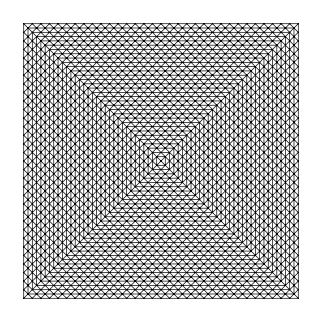

In [44]:
epsilon = 0

m = MeshTri.init_symmetric()
# m = MeshTri()
m.refine(5)
element = {'w': ElementTriP1(), 'u': ElementTriMorley()}
basis = {variable: InteriorBasis(m, e, intorder=4)
    for variable, e in element.items()}  # intorder: integration order for quadrature

draw(m)
plt.show()

### Forms for $\left(\nabla w_{h}, \nabla \chi_{h}\right)=\left(f, \chi_{h}\right)$

In [46]:
@BilinearForm
def laplace(u, v, w):
    '''
    for $(\nabla w_{h}, \nabla \chi_{h})$
    '''
    return dot(grad(u), grad(v))


@LinearForm
def f_load(v, w):
    '''
    for $(f, x_{h})$
    '''
    pix = pi * w.x[0]
    piy = pi * w.x[1]
    lu = 2 * (pi)**2 * (cos(2*pix)*((sin(piy))**2) + cos(2*piy)*((sin(pix))**2))
    llu = - 8 * (pi)**4 * (cos(2*pix)*sin(piy)**2 + cos(2*piy)*sin(pix)**2 - cos(2*pix)*cos(2*piy))
    return (epsilon**2 * llu - lu) * v

### Solving $w_{h}$

In [47]:
%%time

K1 = asm(laplace, basis['w'])
f1 = asm(f_load, basis['w'])

wh = solve(*condense(K1, f1, D=m.boundary_nodes()), solver=solver_iter_krylov(Precondition=True))

Wall time: 19.9 ms


### Forms for $\varepsilon^{2} a_{h}\left(u_{h 0}, v_{h}\right)+b_{h}\left(u_{h 0}, v_{h}\right)=\left(\nabla w_{h}, \nabla_{h} v_{h}\right)$

$$
a_{h}\left(u_{h 0}, v_{h}\right):=\left(\nabla_{h}^{2} u_{h 0}, \nabla_{h}^{2} v_{h}\right), \quad b_{h}\left(u_{h 0}, v_{h}\right):=\left(\nabla_{h} u_{h 0}, \nabla_{h} v_{h}\right)
$$

In [20]:
@BilinearForm
def a_load(u, v, w):
    '''
    for $a_{h}$
    '''
    return ddot(dd(u), dd(v))


@BilinearForm
def b_load(u, v, w):
    '''
    for $b_{h}$
    '''
    return dot(grad(u), grad(v))


@BilinearForm
def wv_load(u, v, w):
    '''
    for $(\nabla \chi_{h}, \nabla_{h} v_{h})$
    '''
    return dot(grad(u), grad(v))

### Setting boundary conditions

In [21]:
def easy_boundary(basis):
    '''
    Input basis
    ----------------
    Return D for boundary conditions
    '''

    dofs = basis.find_dofs({
        'left': m.facets_satisfying(lambda x: x[0] == 0),
        'right': m.facets_satisfying(lambda x: x[0] == 1),
        'top': m.facets_satisfying(lambda x: x[1] == 1),
        'buttom': m.facets_satisfying(lambda x: x[1] == 0)
    })

    D = np.concatenate((dofs['left'].nodal['u'], dofs['right'].nodal['u'],
                        dofs['top'].nodal['u'], dofs['buttom'].nodal['u'],
                        dofs['left'].facet['u_n'], dofs['right'].facet['u_n'],
                        dofs['top'].facet['u_n'], dofs['buttom'].facet['u_n']))
    return D

### Solving $u_{h0}$

In [22]:
%%time

D = easy_boundary(basis['u'])
K2 = epsilon**2 * asm(a_load, basis['u']) + asm(b_load, basis['u'])
f2 = asm(wv_load, basis['w'], basis['u']) * wh
uh0 = solve(*condense(K2, f2, D=D), solver=solver_iter_krylov(Precondition=True)) # cg

Wall time: 65.8 ms


### Computing $L_{2}$ $H_{1}$ $H_{2}$ error with $u_{h0}$ and $u$

In [45]:
def exact_u(x, y):
    return (sin(pi * x) * sin(pi * y))**2

def dexact_u(x, y):
    dux = 2 * pi * cos(pi * x) * sin(pi * x) * sin(pi * y)**2
    duy = 2 * pi * cos(pi * y) * sin(pi * x)**2 * sin(pi * y)
    return dux, duy

def ddexact(x, y):
    duxx = 2*pi**2*cos(pi*x)**2*sin(pi*y)**2 - 2*pi**2*sin(pi*x)**2*sin(pi*y)**2
    duxy = 2*pi*cos(pi*x)*sin(pi*x)*2*pi*cos(pi*y)*sin(pi*y)
    duyx = duxy
    duyy = 2*pi**2*cos(pi*y)**2*sin(pi*x)**2 - 2*pi**2*sin(pi*y)**2*sin(pi*x)**2
    return duxx, duxy, duyx, duyy

@Functional
def L2uError(w):
    x, y = w.x
    return (w.w - exact_u(x, y))**2

def get_DuError(basis, u):
    duh = basis.interpolate(u).grad
    x = basis.global_coordinates().value
    dx = basis.dx  # quadrature weights
    dux, duy = dexact_u(x[0], x[1])
    return np.sqrt(np.sum(((duh[0] - dux)**2 + (duh[1] - duy)**2) * dx))

def get_D2uError(basis, u):
    dduh = basis.interpolate(u).hess
    x = basis.global_coordinates().value  # coordinates of quadrature points [x, y]
    dx = basis.dx  # quadrature weights
    duxx, duxy, duyx, duyy = ddexact(x[0], x[1])
    return np.sqrt(
        np.sum(((dduh[0][0] - duxx)**2 + (dduh[0][1] - duxy)**2 +
                (dduh[1][1] - duyy)**2 + (dduh[1][0] - duyx)**2) * dx))

In [72]:
for i in range(6):  
    epsilon = 1*10**(-i)

    L2_list = []
    Du_list = []
    D2u_list = []
    h_list = []
    epu_list = []
    m = MeshTri()

    for i in range(1, 7):
        m.refine()

        element = {'w': ElementTriP1(), 'u': ElementTriMorley()}
        basis = {variable: InteriorBasis(m, e, intorder=4)
            for variable, e in element.items()}  # intorder: integration order for quadrature

        K1 = asm(laplace, basis['w'])
        f1 = asm(f_load, basis['w'])

        wh = solve(*condense(K1, f1, D=m.boundary_nodes()), solver=solver_iter_krylov(Precondition=True))

        D = easy_boundary(basis['u'])
        K2 = epsilon**2 * asm(a_load, basis['u']) + asm(b_load, basis['u'])
        f2 = asm(wv_load, basis['w'], basis['u']) * wh
        uh0 = solve(*condense(K2, f2, D=D), solver=solver_iter_krylov(Precondition=True))

        U = basis['u'].interpolate(uh0).value

        L2u = np.sqrt(L2uError.assemble(basis['u'], w=U))
        Du = get_DuError(basis['u'], uh0)
        H1u = Du + L2u
        D2u = get_D2uError(basis['u'], uh0)
        H2u = Du + L2u + D2u
        epu = np.sqrt(epsilon**2 * D2u**2 + Du**2)
    #     print('Case 2^-' + str(i))
    #     print('L2 error of uh0:', L2u)
    #     print('H1 error of uh0:', H1u)
    #     print('H2 error of uh0:', H2u)
    #     print('Ep error of uh0:', epu)
        h_list.append(m.param())
        Du_list.append(Du)
        L2_list.append(L2u)
        D2u_list.append(D2u)
        epu_list.append(epu)

    hs = np.array(h_list)
    L2s = np.array(L2_list)
    Dus = np.array(Du_list)
    D2us = np.array(D2u_list)
    epus = np.array(epu_list)
    H1s = L2s + Dus
    H2s = H1s + D2us
    print('epsilon =', epsilon)
    print('  h    L2u   H1u   H2u   epu')
    for i in range(H2s.shape[0] - 1):
        print(
            '2^-' + str(i + 2),
            ' {:.2f}  {:.2f}  {:.2f}  {:.2f}'.format(-np.log2(L2s[i + 1] / L2s[i]),
                                                    -np.log2(H1s[i + 1] / H1s[i]),
                                                    -np.log2(H2s[i + 1] / H2s[i]),
                                                    -np.log2(epus[i + 1] / epus[i])))

epsilon = 1
  h    L2u   H1u   H2u   epu
2^-2  1.79  0.91  0.69  0.67
2^-3  2.19  1.76  1.02  0.98
2^-4  2.16  1.93  1.05  1.02
2^-5  2.06  1.98  1.02  1.01
2^-6  2.02  2.00  1.01  1.00
epsilon = 0.1
  h    L2u   H1u   H2u   epu
2^-2  1.38  0.84  0.60  0.66
2^-3  2.06  1.76  1.07  1.22
2^-4  2.06  1.93  1.08  1.15
2^-5  2.03  1.98  1.04  1.05
2^-6  2.01  2.00  1.01  1.01
epsilon = 0.01
  h    L2u   H1u   H2u   epu
2^-2  1.43  0.77  0.45  0.70
2^-3  2.26  1.67  0.86  1.61
2^-4  2.08  1.94  1.09  1.86
2^-5  1.76  2.03  1.22  1.85
2^-6  1.82  2.02  1.14  1.59
epsilon = 0.001
  h    L2u   H1u   H2u   epu
2^-2  1.43  0.77  0.45  0.70
2^-3  2.29  1.66  0.81  1.61
2^-4  2.31  1.89  0.94  1.87
2^-5  2.12  1.97  0.99  1.96
2^-6  1.98  2.00  1.03  1.99
epsilon = 0.0001
  h    L2u   H1u   H2u   epu
2^-2  1.43  0.77  0.45  0.70
2^-3  2.29  1.66  0.81  1.61
2^-4  2.31  1.89  0.94  1.87
2^-5  2.14  1.97  0.98  1.96
2^-6  2.04  1.99  1.00  1.99
epsilon = 1e-05
  h    L2u   H1u   H2u   epu
2^-2  1.43 

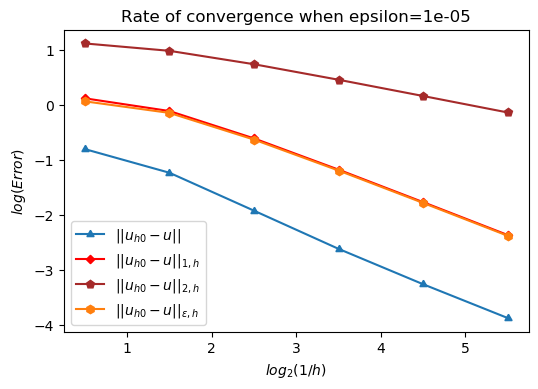

In [74]:
hs_Log = np.log2(hs)

L2plot, = plt.plot(-hs_Log,
                   np.log10(L2s),
                   marker=(3, 0),
                   label='$|\|u_{h0}-u\||}$')
H1plot, = plt.plot(-hs_Log,
                   np.log10(H1s),
                   marker=(4, 0),
                   label=r'$|\left\|{u}_{h0}-u\right\||_{1, h}$',
                   color='red')
H2plot, = plt.plot(-hs_Log,
                   np.log10(H2s),
                   marker=(5, 0),
                   label=r'$|\left\|{u}_{h0}-u\right\||_{2, h}$',
                   color='brown')
epplot, = plt.plot(-hs_Log,
                   np.log10(epus),
                   marker=(6, 0),
                   label='$\|\|{u}_{h0}-u\|\|_{\epsilon, h}$')

plt.legend(handles=[L2plot, H1plot, H2plot, epplot])
plt.title('Rate of convergence when epsilon='+str(epsilon))
plt.xlabel('$log_{2}(1/h)$')
plt.ylabel('$log(Error)$')
plt.show()

## Expamle 2 :

In [ ]:
@LinearForm
def f_load(v, w):
    '''
    for $(f, x_{h})$
    '''
    pix = pi * w.x[0]
    piy = pi * w.x[1]
    lu = 2 * (pi)**2 * (cos(2*pix)*((sin(piy))**2) + cos(2*piy)*((sin(pix))**2))
    llu = - 8 * (pi)**4 * (cos(2*pix)*sin(piy)**2 + cos(2*piy)*sin(pix)**2 - cos(2*pix)*cos(2*piy))
    return (epsilon**2 * llu - lu) * v

In [ ]:
def exact_u(x, y):
    return (sin(pi * x) * sin(pi * y))**2

def dexact_u(x, y):
    dux = 2 * pi * cos(pi * x) * sin(pi * x) * sin(pi * y)**2
    duy = 2 * pi * cos(pi * y) * sin(pi * x)**2 * sin(pi * y)
    return dux, duy

def ddexact(x, y):
    duxx = 2*pi**2*cos(pi*x)**2*sin(pi*y)**2 - 2*pi**2*sin(pi*x)**2*sin(pi*y)**2
    duxy = 2*pi*cos(pi*x)*sin(pi*x)*2*pi*cos(pi*y)*sin(pi*y)
    duyx = duxy
    duyy = 2*pi**2*cos(pi*y)**2*sin(pi*x)**2 - 2*pi**2*sin(pi*y)**2*sin(pi*x)**2
    return duxx, duxy, duyx, duyy

@Functional
def L2uError(w):
    x, y = w.x
    return (w.w - exact_u(x, y))**2

def get_DuError(basis, u):
    duh = basis.interpolate(u).grad
    x = basis.global_coordinates().value
    dx = basis.dx  # quadrature weights
    dux, duy = dexact_u(x[0], x[1])
    return np.sqrt(np.sum(((duh[0] - dux)**2 + (duh[1] - duy)**2) * dx))

def get_D2uError(basis, u):
    dduh = basis.interpolate(u).hess
    x = basis.global_coordinates().value  # coordinates of quadrature points [x, y]
    dx = basis.dx  # quadrature weights
    duxx, duxy, duyx, duyy = ddexact(x[0], x[1])
    return np.sqrt(
        np.sum(((dduh[0][0] - duxx)**2 + (dduh[0][1] - duxy)**2 +
                (dduh[1][1] - duyy)**2 + (dduh[1][0] - duyx)**2) * dx))

## Problem 2

The modified Morley-Wang-Xu element method is also equivalent to
$$
\begin{aligned}
\left(\nabla w_{h}, \nabla \chi_{h}\right) &=\left(f, \chi_{h}\right) & & \forall \chi_{h} \in W_{h} \\
\varepsilon^{2} \tilde{a}_{h}\left(u_{h}, v_{h}\right)+b_{h}\left(u_{h}, v_{h}\right) &=\left(\nabla w_{h}, \nabla_{h} v_{h}\right) & & \forall v_{h} \in V_{h}
\end{aligned}
$$
where
$$
\tilde{a}_{h}\left(u_{h}, v_{h}\right):=\left(\nabla_{h}^{2} u_{h}, \nabla_{h}^{2} v_{h}\right)-\sum_{F \in \mathcal{F}_{h}^{\partial}}\left(\partial_{n n}^{2} u_{h}, \partial_{n} v_{h}\right)_{F}-\sum_{F \in \mathcal{F}_{h}^{\partial}}\left(\partial_{n} u_{h}, \partial_{n n}^{2} v_{h}\right)_{F}+\sum_{F \in \mathcal{F}_{h}^{0}} \frac{\sigma}{h_{F}}\left(\partial_{n} u_{h}, \partial_{n} v_{h}\right)_{F}
$$

# Other codes

In [52]:
# plot(basis['u'], uh0, colorbar=True)
# plt.show()

# ### Showing exact $u$

# u = exact_u(basis['u'].doflocs[0], basis['u'].doflocs[1])

# plot(basis['u'], u, colorbar=True)
# plt.show()

# ### Visualizing error $u - u_{h0}$

# plot(basis['u'], u-uh0, colorbar=True)
# plt.show()

In [48]:
# def exact_w(x, y):
#     pix = pi * x
#     piy = pi * y
#     lu = 2 * (pi)**2 * (cos(2 * pix) * sin(piy)**2 +
#                         cos(2 * piy) * sin(pix)**2)
#     u = (sin(pix) * sin(piy))**2
#     return -(epsilon**2 * lu - u)


# plot(basis['w'], wh, colorbar=True)
# plt.show()

# w = exact_w(basis['w'].doflocs[0], basis['w'].doflocs[1])

# plot(basis['w'], w, colorbar=True)
# plt.show()

# plot(basis['w'], w - wh, colorbar=True)
# plt.show()

In [77]:
# U = basis['u'].interpolate(uh0).value

# L2u = np.sqrt(L2uError.assemble(basis['u'], w=U))
# print('L2 error of uh0:', L2u)

# Du = get_DuError(basis['u'], uh0)
# print('Du error ', Du)

# D2u = get_D2uError(basis['u'], uh0)
# print('D2u error ', D2u)

In [76]:
# epsilon = 1e-5

# L2_list = []
# Du_list = []
# D2u_list = []
# h_list = []
# epu_list = []
# m = MeshTri()

# for i in range(1, 7):
#     m.refine()

#     element = {'w': ElementTriP1(), 'u': ElementTriMorley()}
#     basis = {variable: InteriorBasis(m, e, intorder=4)
#         for variable, e in element.items()}  # intorder: integration order for quadrature

#     K1 = asm(laplace, basis['w'])
#     f1 = asm(f_load, basis['w'])

#     wh = solve(*condense(K1, f1, D=m.boundary_nodes()), solver=solver_iter_krylov(Precondition=True))

#     D = easy_boundary(basis['u'])
#     K2 = epsilon**2 * asm(a_load, basis['u']) + asm(b_load, basis['u'])
#     f2 = asm(wv_load, basis['w'], basis['u']) * wh
#     uh0 = solve(*condense(K2, f2, D=D), solver=solver_iter_krylov(Precondition=True))

#     U = basis['u'].interpolate(uh0).value

#     L2u = np.sqrt(L2uError.assemble(basis['u'], w=U))
#     Du = get_DuError(basis['u'], uh0)
#     H1u = Du + L2u
#     D2u = get_D2uError(basis['u'], uh0)
#     H2u = Du + L2u + D2u
#     epu = np.sqrt(epsilon**2 * D2u**2 + Du**2)
#     print('Case 2^-' + str(i))
#     print('L2 error of uh0:', L2u)
#     print('H1 error of uh0:', H1u)
#     print('H2 error of uh0:', H2u)
#     print('Ep error of uh0:', epu)
#     h_list.append(m.param())
#     Du_list.append(Du)
#     L2_list.append(L2u)
#     D2u_list.append(D2u)
#     epu_list.append(epu)

# hs = np.array(h_list)
# L2s = np.array(L2_list)
# Dus = np.array(Du_list)
# D2us = np.array(D2u_list)
# epus = np.array(epu_list)
# H1s = L2s + Dus
# H2s = H1s + D2us
# print('epsilon =', epsilon)
# print('  h    L2u   H1u   H2u   epu')
# for i in range(H2s.shape[0] - 1):
#     print(
#         '2^-' + str(i + 2),
#         ' {:.2f}  {:.2f}  {:.2f}  {:.2f}'.format(-np.log2(L2s[i + 1] / L2s[i]),
#                                                 -np.log2(H1s[i + 1] / H1s[i]),
#                                                 -np.log2(H2s[i + 1] / H2s[i]),
#                                                 -np.log2(epus[i + 1] / epus[i])))